In [1]:
from scipy.stats import multivariate_normal, dirichlet, wishart, multivariate_normal as normal
from scipy.special import psi,gammaln
from scipy.linalg import sqrtm
from numpy.linalg import det,inv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


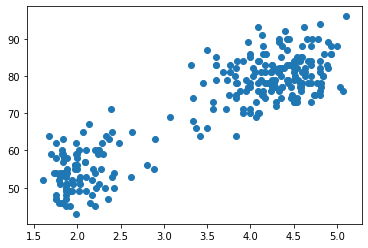

In [2]:
# Load data
X = np.loadtxt('oldfaithful.csv', delimiter=',', skiprows=1)

plt.scatter(X[:,0],X[:,1])
plt.show()

In [3]:
nsample = 500
c=5
d=2
pi = [0.4, 0.25, 0.2, 0.1, 0.05]
mu = [[-3, 3], [2, 4], [0, 0], [4, -2], [-2, -4]]
cov = [[[.4, -.4], [-.4, .6]],\
        [[.7, .6], [.6, .6]],\
        [[.3, .2], [.2, .5]],\
        [[.3, 0], [0, .3]],\
        [[.5, .1], [.1, .5]]]

X = []
for i in range(c):
    num = int(pi[i] * nsample)
    for j in range(num):
        X.append(normal.rvs(mu[i], cov[i]))

X = np.array(X)


In [4]:
class VBGMM:
    def __init__(self, X, K, alpha0, m0, beta0, W0, nu0):
        self.eps = np.finfo(np.float).eps
        
        # Hyper Parameters
        self.K = K
        self.alpha0 = alpha0
        self.m0 = m0
        self.beta0 = beta0
        self.W0 = W0
        self.nu0 = nu0
        
        # Data
        self.X = X
        self.N_data = X.shape[0]
        self.D = X.shape[1]
        
        # Parameters
        self.alpha = alpha0*np.ones(K)
        self.m = np.tile(np.mean(X,axis=0),(K,1))
        for k in range(K):
            self.m[k,:] += np.std(X,axis=0)*np.random.randn(2)*2
        self.beta = beta0*np.ones(K)
        self.W = np.tile(W0, (K,1,1))
        self.nu = nu0*np.ones(K)

        self.N = np.zeros(K)
        self.x_bar = np.zeros([self.K,self.D])
        self.S = np.zeros([K,self.D,self.D])
    
        
        self.r = np.zeros([self.N_data,self.K])
        self.rho = np.zeros([self.N_data,self.K])
       
    def update_rho(self):
        ln_pi_tilde = self.calc_ln_pi_tilde()
        ln_Lambda_tilde = self.calc_ln_Lambda_tilde()
        self.calc_quadra(X[0,:]-self.m[0], self.W[0,:,:])
        for n in range(self.N_data):
            for k in range(self.K):
                ln_rho_nk = ln_pi_tilde[k] + 1/2*ln_Lambda_tilde[k] - self.D/2*np.log(2*np.pi + self.eps) \
                            -1/2*(self.D/self.beta[k] + self.nu[k]*self.calc_quadra(X[n,:]-self.m[k],self.W[k,:,:]))
                self.rho[n,k] = ln_rho_nk
                
        # prevent overflow
        self.rho =  self.rho - np.max(self.rho,axis=1).reshape([-1,1])
        self.rho = np.exp(self.rho) + self.eps
        
                
    def calc_ln_pi_tilde(self):
        ln_pi_tilde = np.zeros(self.K)
        sum_alpha = np.sum(self.alpha)
        for k in range(self.K):
            ln_pi_tilde[k] = psi(self.alpha[k]) - psi(sum_alpha)
        
        return ln_pi_tilde
            
    def calc_ln_Lambda_tilde(self):
        ln_Lambda_tilde = np.zeros(self.K)
        for k in range(self.K):
            sum_digamma = 0
            for d in range(self.D):
                sum_digamma += psi((self.nu[k]+1-(d+1))/2)
            ln_Lambda_tilde[k] = sum_digamma + self.D*np.log(2) + np.log(det(self.W[k,:,:] + self.eps) + self.eps)
        return ln_Lambda_tilde
                                           
    def update_r(self):
        self.update_rho()
        sum_rho = np.sum(self.rho,axis=1)+self.eps
        for n in range(self.N_data):
            for k in range(self.K):
                self.r[n,k] = self.rho[n,k] / sum_rho[n]
        
    def update_N(self):
        self.N = np.sum(self.r,axis=0)
            
    def update_x_bar(self):
        for k in range(self.K):
            self.x_bar[k,:] = 1/self.N[k]*np.sum(self.r[:,k].reshape(-1,1)*self.X, axis=0)    
            
    def update_S(self):
        for k in range(self.K):
            X_center = X[:]-self.x_bar[k]
            self.S[k,:,:] = 1/self.N[k]*np.dot(self.r[:,k]*X_center.T, X_center)

    def update_alpha(self):
        self.alpha = self.alpha0 + self.N

    def update_beta(self):
        self.beta = self.beta0 + self.N
                                  
    def update_m(self):
        self.m = 1/self.beta.reshape([-1,1])*(self.beta0*self.m0.reshape([1,-1])+self.N.reshape([-1,1])*self.x_bar)
    
    def update_W(self):
        for k in range(self.K):
            W_inv = inv(self.W0) + self.N[k]*self.S[k,:,:] \
            + self.beta0*self.N[k]/(self.beta0 + self.N[k])*np.outer((self.x_bar[k]-self.m0), (self.x_bar[k]-self.m0))
            self.W[k,:,:] = inv(W_inv+self.eps)
        
            
    def update_nu(self):
        self.nu = self.nu0 + self.N
        
    def calc_quadra(self,x,A):
        quadra = np.dot(np.dot(x,A),x)
        return quadra
        

    def est_post(self, max_iter=300):
        frame_mu = []
        frame_Sigma = []
        frame_idx = []
        frame_elbo = []
        frame_mixture_C = []
        for i in range(max_iter):
            self.update_r()
            self.update_N()
            self.update_x_bar()
            self.update_S()
            self.update_alpha()
            self.update_beta()
            self.update_m()
            self.update_nu()
            self.update_W()
            
            frame_mu.append(self.m.copy())
            frame_Sigma.append(inv(self.nu.reshape([-1,1,1]).copy()*self.W.copy()))
            idx = np.argmax(self.r,axis=1)
            frame_idx.append(idx.copy())
            
            mixture_C = np.zeros(self.K)
            for k in range(self.K):
                mixture_C[k] = np.count_nonzero(idx==k)
            frame_mixture_C.append(mixture_C)
            frame_elbo.append(self.calc_elbo())
        frame_mixture_C = np.array(frame_mixture_C)
        return frame_mu, frame_Sigma, frame_idx, frame_elbo ,frame_mixture_C
    
    
    def calc_elbo(self):
        elbo = 0
        elbo += self.calc_ln_C(alpha0*np.ones(self.K)) - self.calc_ln_C(self.alpha)
        for k in range(self.K):
            elbo += (self.D/2*(np.log(self.beta0 + self.eps) - np.log(self.beta[k] + self.eps)))
            elbo += (self.calc_ln_B_W_nu(self.W0, self.nu0) - self.calc_ln_B_W_nu(self.W[k], self.nu[k]))
        elbo -= np.sum(self.r*np.log(self.r + self.eps))
        elbo -= self.D*self.N_data/2*np.log(2*np.pi)
        
        return elbo
    
    def calc_ln_C(self,alpha):
        ln_C = gammaln(np.sum(alpha) + self.eps)
        for k in range(K):
            ln_C -= gammaln(alpha[k] + self.eps)
        return ln_C
    
    def calc_ln_B_W_nu(self,W,nu):
        ln_B_W_nu = -nu/2*np.log(det(W + self.eps) + self.eps) - nu*self.D/2*np.log(2) - self.D*(self.D-1)/4*np.log(np.pi)
        for d in range(self.D):
            ln_B_W_nu -= gammaln((nu+1+(d+1))/2 + self.eps)
        return ln_B_W_nu
        
        
                                           
        

In [14]:
# Set hyper parameters
K = 10
D = 2
alpha0 = np.ones([1])*0.5
m0 = np.zeros(D)
beta0 = np.ones([1])*1
W0 = np.eye(2)*100
nu0 = np.array([D])

In [15]:
# Initialize
vbgmm = VBGMM(X,K,alpha0,m0,beta0,W0,nu0)
max_iter=80
frame_mu, frame_Sigma, frame_idx, frame_elbo, frame_mixture_C = vbgmm.est_post(max_iter)

<IPython.core.display.Javascript object>


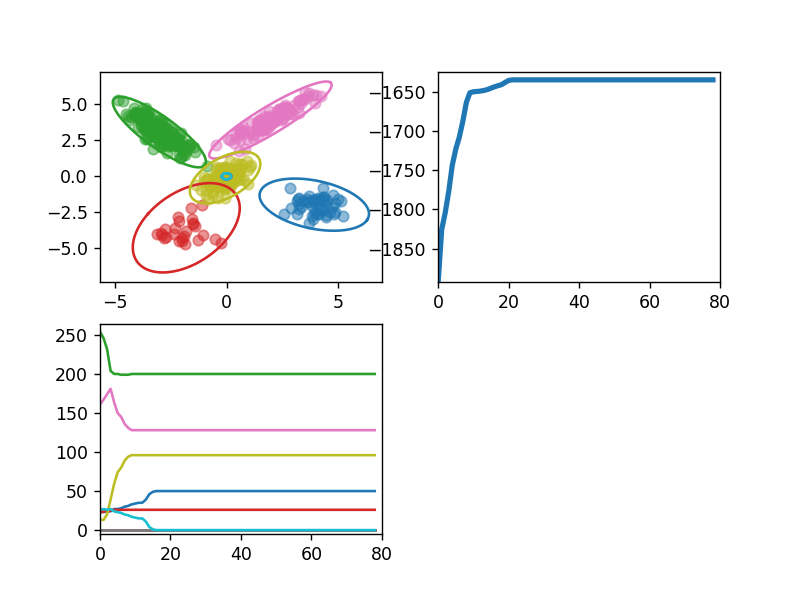

In [16]:
%matplotlib nbagg

def ellipse(mu,Sigma,n_sig=3):
    mu = mu.reshape([2,1])
    V,W = np.linalg.eig(Sigma)
    ax_x,ax_y = V**(1/2)
    
    t = np.linspace(0,2*np.pi,100)
    xy = np.vstack([ax_x*n_sig*np.cos(t),ax_y*n_sig*np.sin(t)])
    
    xy = np.dot(W,xy)
    xy = xy + mu
    return xy[0],xy[1]
    

def update_graph(frame, ax1, ax2, ax3, max_iter, X, frame_idx, frame_mu, frame_Sigma, frame_elbo, frame_mixture_C, n_sig=3):
    ax1.cla()
    ax2.cla()
    ax3.cla()
    list_idx = frame_idx[frame]
    list_mu = frame_mu[frame]
    list_Sigma = frame_Sigma[frame]
    K = len(list_mu)

    for k in range(K):
        idx = np.where(list_idx==k)
        ax1.scatter(X[idx,0],X[idx,1],alpha=0.5)
        ell_x,ell_y = ellipse(list_mu[k],list_Sigma[k],n_sig)
        ax1.plot(ell_x, ell_y)
#         ax1.set_xlim(np.min(X[:,0]), np.max(X[:,0]))
#         ax1.set_ylim(np.min(X[:,1]), np.max(X[:,1]))

        
    ax2.plot(frame_elbo[:frame],linewidth = 3)
    ax2.set_xlim(0,max_iter)
    ylim_max = max(frame_elbo)
    ylim_min = min(frame_elbo)
    ax2.set_ylim(ylim_min, ylim_max+10)
    
    ax3.plot(frame_mixture_C[:frame,:])
    ax3.set_ylim(-5,np.max(frame_mixture_C)+10)
    ax3.set_xlim(0,max_iter)

n_sig = 3
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)

ani = FuncAnimation(fig, update_graph, fargs = (ax1,ax2,ax3,max_iter,X,frame_idx,frame_mu,frame_Sigma,frame_elbo, frame_mixture_C,n_sig), \
    interval = 200, frames = max_iter)
# ani.save("vb-gmm.gif", writer="imagemagick")